<center>
<div style="max-width:400px;">

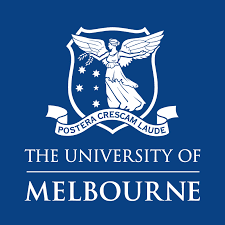

</div>
</center>

# Analysis of Variance (ANOVA)

**Prof. Kevin Otto and Nikolas Crossan**  
The University of Melbourne  
Department of Mechanical Engineering

----------------------------------------------------------------------------

This notebook demonstrates one-way and two-way ANOVA analysis.  

This notebook relies on the `mqrpy` code library, found at https://pypi.org/project/mqrpy/


---------------------------------------------------------------------------------------------------------

# 1.0 One-Way ANOVA


Load code libraries needed for ANOVA.
We will use Pandas dateframes for ease of viewing and use.

In [1]:
import mqr
from mqr.plot import Figure
from mqr.nbtools import hstack, vstack

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

In [2]:
from importlib.metadata import version
print('MQR version', version('mqrpy'))
print('Numpy version', version('numpy'))
print('Scipy version', version('scipy'))
print('Pandas version', version('pandas'))
print('Statsmodels version', version('statsmodels'))
print('Seaborn version', version('seaborn'))

MQR version 0.6.0
Numpy version 1.26.4
Scipy version 1.13.1
Pandas version 2.2.2
Statsmodels version 0.14.1
Seaborn version 0.13.2


Define a one-way dataframe.
Print out the first 5 rows.

In [3]:
data = {'Capacity':[8248, 7884, 7876, 7876, 7867, 
                    8395, 7983, 7996, 8047, 7955,
                    8434, 7999, 7972, 8036, 8012,
                    8363, 8014, 7954, 7956, 8038],
       'Location': np.repeat([1, 2, 3, 4], 5)}
df = pd.DataFrame(data)
df.head()

,Capacity,Location
0,8248,1
1,7884,1
2,7876,1
3,7876,1
4,7867,1


Run a one-way ANOVA analysis using StatsModel's `ols`.  Use a type II sum of squares. Ensure the Location is treated as a character variables with the 'C' syntax.  

Print out the one-way ANOVA table as a Pandas dataframe.

In [4]:
model = ols('Capacity ~ C(Location)', data=df).fit()

vstack(
    '### Capacity ANOVA',
    mqr.anova.summary(model)
)

,df,sum_sq,mean_sq,F,PR(>F)
C(Location),3,6.189e+04,2.063e+04,0.65,0.595
Residual,16,5.092e+05,3.182e+04,nan,nan
Total,19,5.711e+05,3.006e+04,nan,nan


The result above is the p-value is not low at p = 0.60. We fail to reject the null hypothesis that all capacities are the same.  As far as we can tell, we get the same capacity at each location.

Now compute the summary statistics.

In [5]:
vstack('### Adequacy stats', mqr.anova.adequacy(model))

,S,R-sq,R-sq (adj),F,PR(>F),AIC,BIC,N
,178.4,0.1084,-0.0588,0.65,0.595,267.7,271.6,20


The result is the RMS error is $\pm$178, so the 2 sigma error is about $\pm$356 units.  This can be judged for engineering practicality.

The $r^2$ is very low at 10%.  The $r^2_{adjusted}$ is terrible as a negative value.


We can graph more with the residuals.  Calculate these and append to the df Dataframe.  

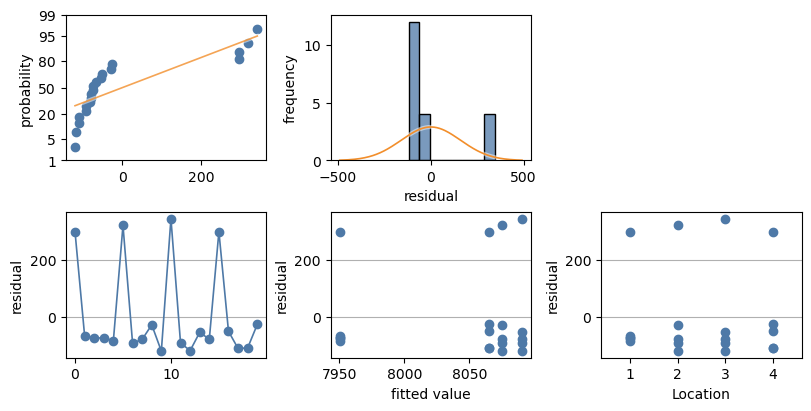

In [6]:
with Figure(8, 4, m=2, n=3) as (fig, axs):
    mqr.plot.regression.residuals(model.resid, model.fittedvalues, axs=axs[:, :2])

    # Add per-factor residuals
    mqr.plot.regression.res_v_factor(model.resid, df['Location'], axs[1, 2], factor_name='Location')

    # Remove unused axes
    axs[0, 2].axis('off')

The **bottom right** graph is a scatter plot of residuals vs location.
Each location scatter should look the same and normally distributed.
They are the same at each Location value, but they are not normally distributed at each Location value.
The residuals are not acceptable.

The **bottom centre** graph is a scatter plot of residuals vs fitted value.
There should be no trend like a quadratic etc. with the X-axis. There is not, so good.
There should be no increase/decrease in variance with the x-axis, there is not, so good.
Each x-axis value should have residuals that look normally distributed.
They do not, so we have a problem and the residuals are again not acceptable.

The **top right** graph is a histogram of the residuals.
The histogram should look normal (the density has mean and stddev from the sample).
They do not, and so again the residuals are not acceptable. 

The **bottom left** graph are the residuals vs run order.
The order was not randomized, so this graph is not informative and should be ignored.

The **top left** is quantile-quantile plot.
The straight line is the CDF (transformed to be linear) of a gaussian with zero mean and standard deviation from the residuals.
If the residuals are close to normally distributed, they will be close to the red line.
They are not, so the residuals are not acceptable here, either.

Based on these residual results, the ANOVA results cannot be accepted.
Right now the one-way ANOVA result of no-difference we cannot accept.
We need better residuals.
Some other effect is going on to make them not normal.  

Next we graph the mean result at each value (location) complete with a 95% confidence interval.

,count,mean,lower,upper
Location,,,,
1,5,7950.2,7781.077787,8119.322213
2,5,8075.2,7906.077787,8244.322213
3,5,8090.6,7921.477787,8259.722213
4,5,8065.0,7895.877787,8234.122213

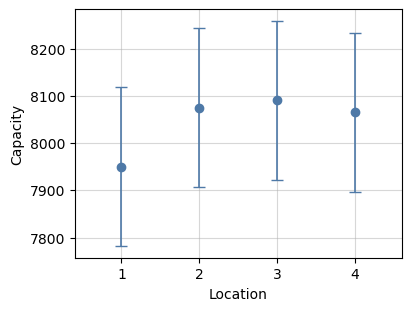

In [7]:
groups_df = mqr.anova.groups(model, value='Capacity', factor='Location', conf=0.95, formatted=False)

with Figure(4, 3) as (fig, ax):
    gs = mqr.plot.anova.groups(groups_df, ax=ax)
    ax.set_ylabel('Capacity')
    ax.set_xlabel('Location')
    plot = mqr.nbtools.grab_figure(fig)

vstack(
   '### Capacity Main Effects Plot',
   hstack(plot, groups_df)
)

We see the ANOVA results graphically as the mean result at each value (each location) complete with a 95% confidence interval about the mean.  This shows that the mean of each column is within the confidence interval of all other columns.  The averages would seem not significantly different.  

--------------------------------------------------------------------------------------------------------------------

# 2.0 Two Way ANOVA

Define a Dataframe with the data including two columns of inputs, here location and day.  

In [8]:
data = {'Capacity':[8248, 7884, 7876, 7876, 7867, 
                    8395, 7983, 7996, 8047, 7955,
                    8434, 7999, 7972, 8036, 8012,
                    8363, 8014, 7954, 7956, 8038],
       'Location': np.repeat([1, 2, 3, 4], 5),
       'Day': np.tile(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], 4)}

df = pd.DataFrame(data)
df.head()

,Capacity,Location,Day
0,8248,1,Mon
1,7884,1,Tue
2,7876,1,Wed
3,7876,1,Thu
4,7867,1,Fri


Now perform a two way ANOVA using statmodels `ols`.  Display both the summary statistics and the ANOVA table.

In [9]:
model = ols('Capacity ~ C(Location) + C(Day)', data=df).fit()

vstack(
    '### Capacity ANOVA',
    mqr.anova.adequacy(model),
    mqr.anova.summary(model)   
)

We can graph the residuals.  Calculate these and append to the df Dataframe. 

In [10]:
df['resid'] = model.resid
df['pred'] = df['Capacity']-df['resid']
df.head()

,Capacity,Location,Day,resid,pred
0,8248,1,Mon,-16.95,8264.95
1,7884,1,Tue,9.05,7874.95
2,7876,1,Wed,21.55,7854.45
3,7876,1,Thu,-7.70,7883.70
4,7867,1,Fri,-5.95,7872.95


Now create graphs of the residuals.  

Display as the residuals stacked side by side with the statistics and tables.


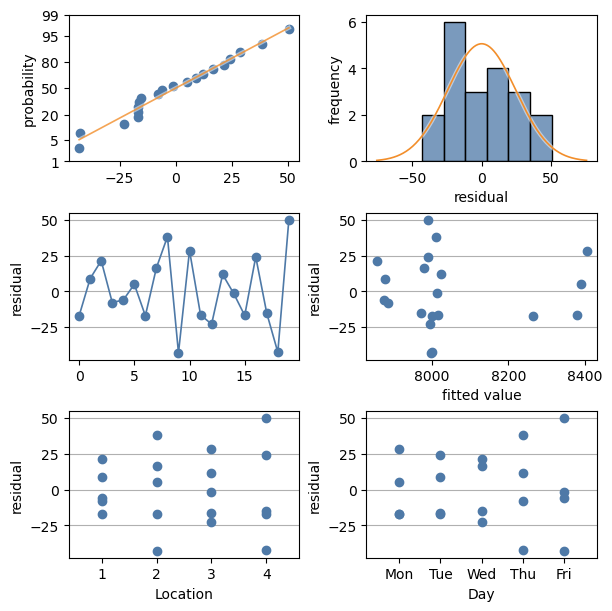

In [11]:
with Figure(6, 6, m=3, n=2) as (fig, axs):
    mqr.plot.regression.residuals(model.resid, model.fittedvalues, axs=axs[:2, :])

    # Add per-factor residuals
    mqr.plot.regression.res_v_factor(model.resid, df['Location'], axs[2, 0], factor_name='Location')
    mqr.plot.regression.res_v_factor(model.resid, df['Day'], axs[2, 1], factor_name='Day')
    plot = mqr.nbtools.grab_figure(fig)

vstack(
'### Capacity ANOVA Results',
hstack(
    vstack(
        mqr.anova.adequacy(model),
        mqr.anova.summary(model),
        mqr.inference.dist.test_1sample(model.resid)
    ),
    plot
))

The **bottom two** scatter plots of residuals vs location and day.
Each location and day scatter should look the same and normally distributed.

The **middle left** should be ignored again, since the runs were not randomised.

The next **middle right** is a scatter plot of residuals vs fitted value.
There should be no trend like a quadratic etc., and no increase/decrease in variance, and each should look normally distributed.  

The **top right** is a histogram of the residuals.
The histogram should look normal.

The **top left** shows the quantile-quantile plot, and values should be close to the CDF line.

Finally, an Anderson-Darling test cannot produce evidence against normality.

--------------------------------------------------------------------------------------
Next, to see which site and day are different from others, we can graph these.

,count,mean,lower,upper
Location,,,,
1,5,7950.2,7919.370504,7981.029496
2,5,8075.2,8044.370504,8106.029496
3,5,8090.6,8059.770504,8121.429496
4,5,8065.0,8034.170504,8095.829496
,count,mean,lower,upper
Day,,,,
Mon,4,8360.00,7935.531576,8004.468424
Tue,4,7970.00,7944.281576,8013.218424
Wed,4,7949.50,7933.531576,8002.468424

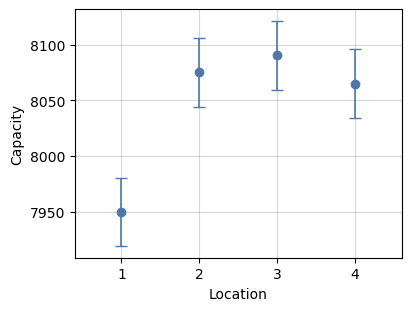
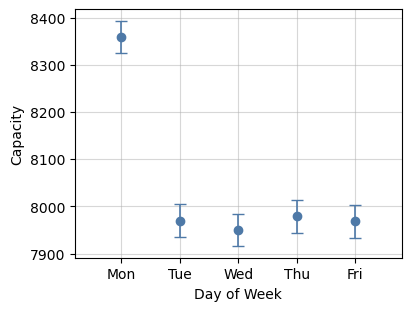

In [12]:
groups_loc = mqr.anova.groups(model, value='Capacity', factor='Location', conf=0.95, formatted=False)
groups_day = mqr.anova.groups(model, value='Capacity', factor='Day', conf=0.95, formatted=False)

with Figure(4, 3) as (fig, ax):
    gs = mqr.plot.anova.groups(groups_loc, ax=ax)
    ax.set_ylabel('Capacity')
    ax.set_xlabel('Location')
    plot_loc = mqr.nbtools.grab_figure(fig)

with Figure(4, 3) as (fig, ax):
    gs = mqr.plot.anova.groups(groups_day, ax=ax)
    ax.set_ylabel('Capacity')
    ax.set_xlabel('Day of Week')
    plot_day = mqr.nbtools.grab_figure(fig)

vstack(
    '### Capacity Treatment Plots',
    hstack(plot_loc, groups_loc),
    hstack(plot_day, groups_day)
)

We see this graphically by graphing the mean result at each value (each location) complete with a 95% confidence interval about the mean.  Previously the one-way ANOVA of location alone showed that the mean of each column was within the confidence interval of all other columns, no difference in sites.  Now with a two-way ANOVA we see there is a difference, Monday and Test Stand 1 means are outside the confidence intervals of at least one other columns and are different. 